In [20]:
import os
import pandas as pd
import glob
import stagger
from stagger import read_tag

import librosa
from librosa import feature

from matplotlib import pyplot as plt
from librosa import display
import seaborn as sns
import numpy as np


In [22]:
#wykrycie ścieżki, w której przechowuje pliki i program
working_directory = os.getcwd()
path = working_directory + '/wrapped/big data projekt/*.mp3'

#probka 5 utworow
songs = [working_directory + '/wrapped/big data projekt/15 Step.mp3',working_directory + '/wrapped/big data projekt/A Forest.mp3',working_directory + '/wrapped/big data projekt/Antitaxi.mp3' , working_directory + '/wrapped/big data projekt/Starman - 2012 Remaster.mp3',working_directory + '/wrapped/big data projekt/sleepwalker.mp3']

In [23]:
#lista cech do wyświetlenia
features = [
    'chroma_stft',
    'spectral_centroid',
    'spectral_bandwidth',
    'spectral_rolloff']

In [24]:
#ustalenie liczby kolumn i wierszy w obrazku
num_cols = 4
num_songs = len(songs)
num_rows = num_songs


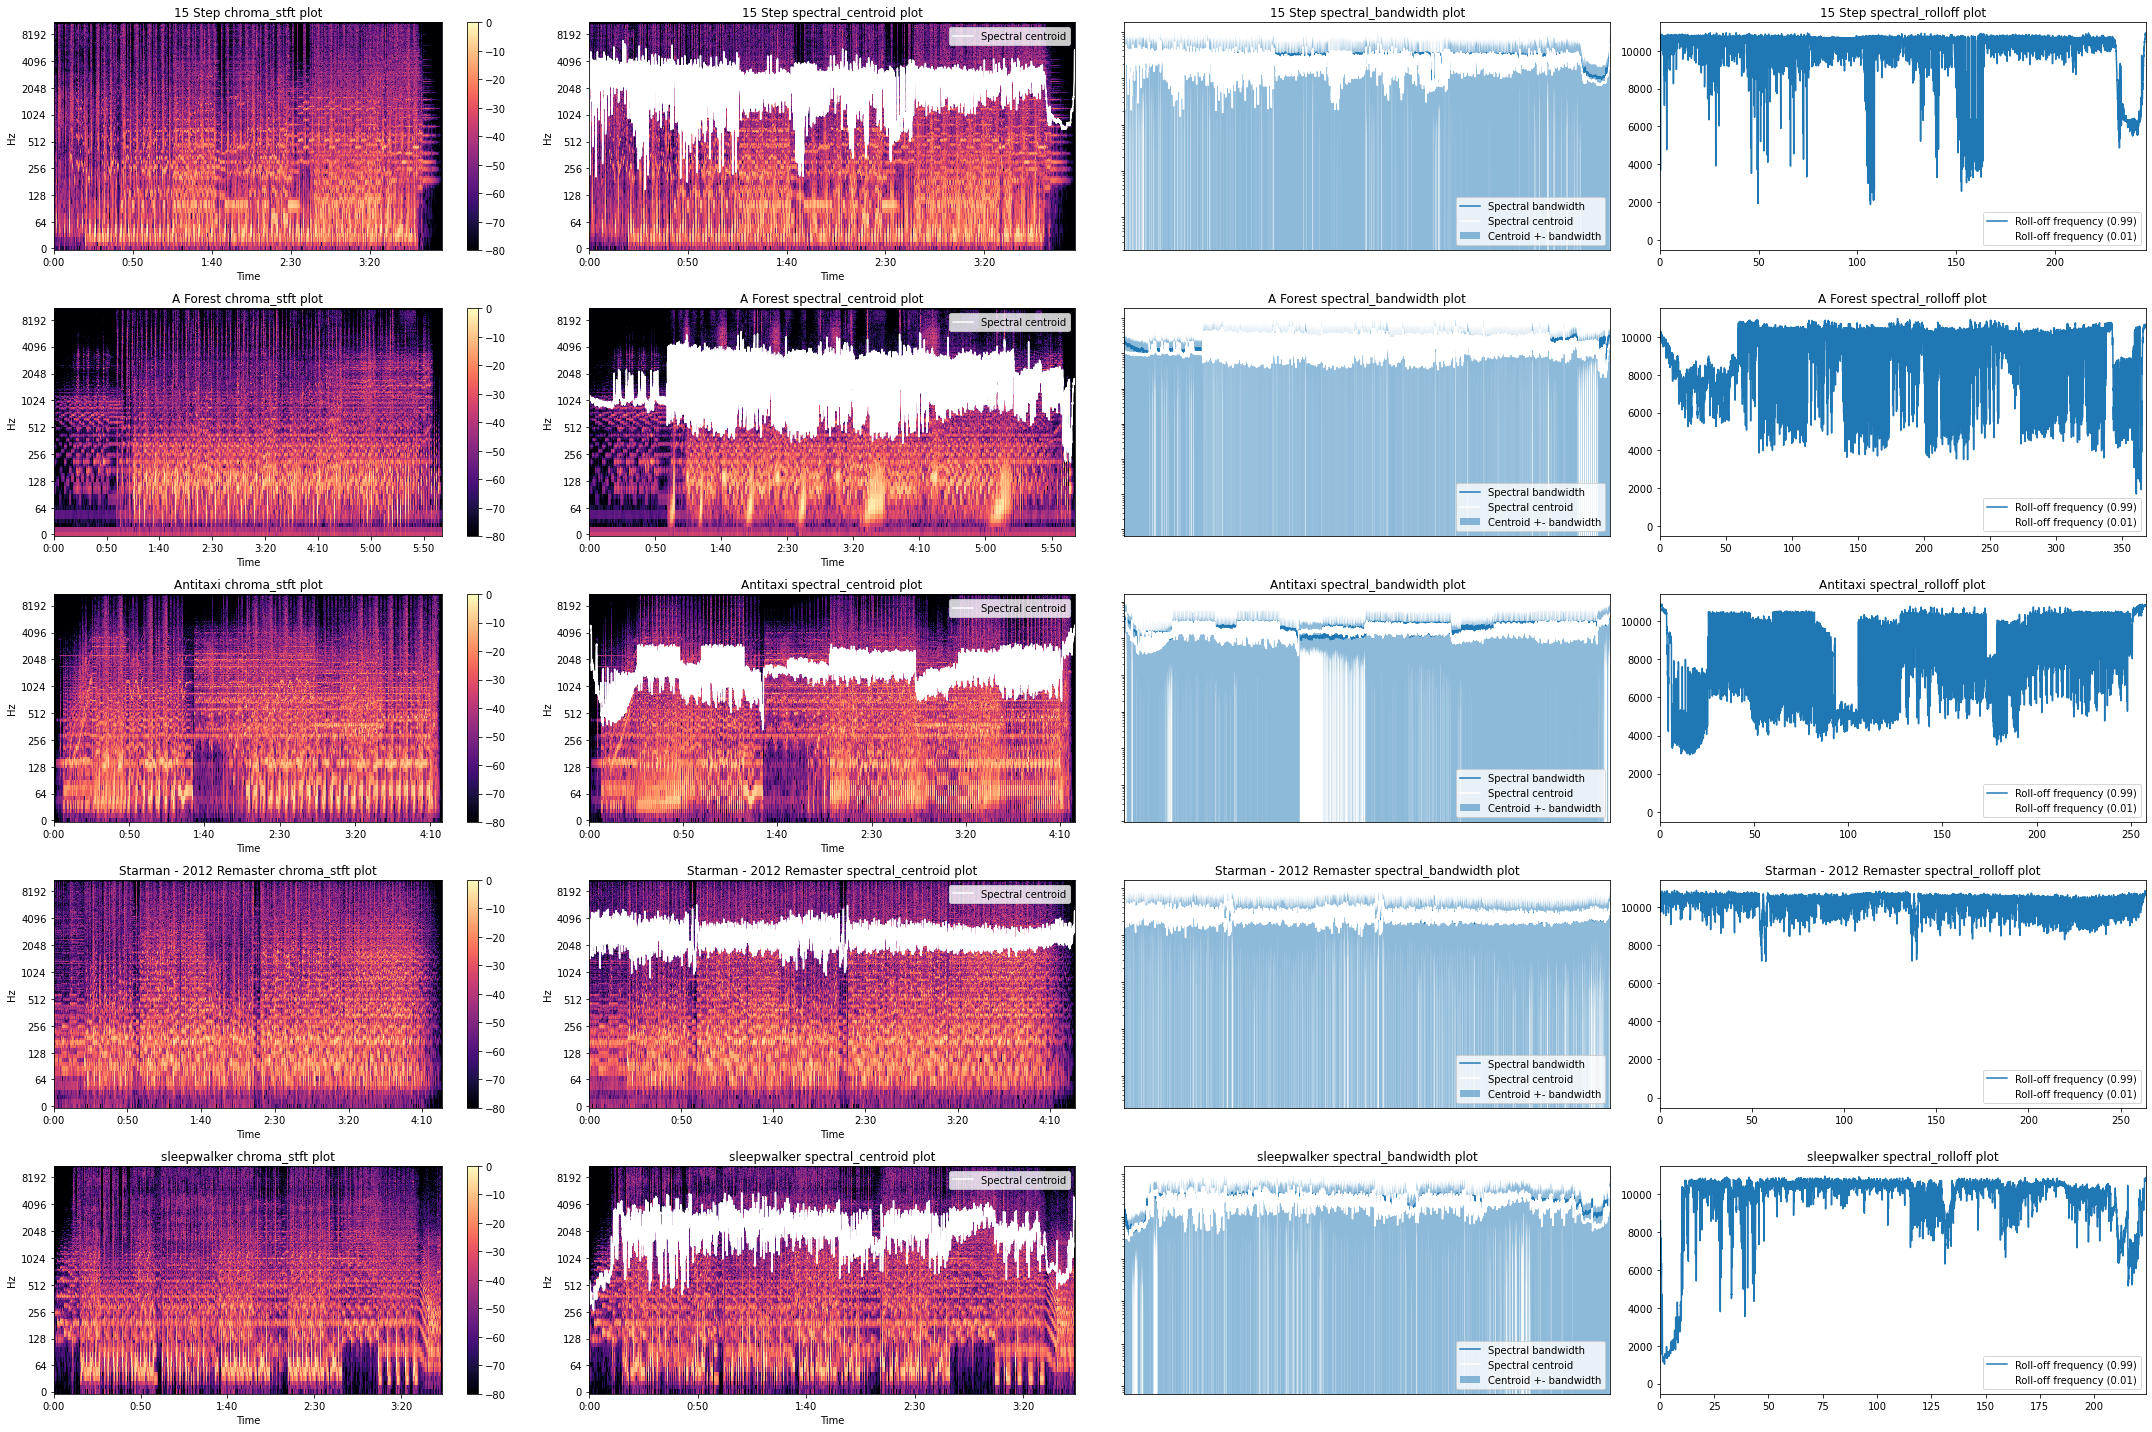

In [26]:
#tworzenie obrazka z subplotami
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 4*num_songs))
for i, song in enumerate(songs):
    mp3 = stagger.read_tag(song)  #pobranie nazwy piosenki
    y, sr = librosa.load(song, sr=22858)  #ustawienie częstotliwości (sampling_rate na 22858 Hz)

    # Iteracja po cechach
    for j, feature in enumerate(features):
        ax = axs[i, j]  #wybór pozycji podwykresu

        if feature == 'chroma_stft':
            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            S = np.abs(librosa.stft(y))

            img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                                           y_axis='log', x_axis='time', ax=ax)
            fig.colorbar(img, ax=ax)
            ax.set_title(f'{mp3.title} {feature} plot')

        elif feature == 'spectral_centroid':
            cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            S, phase = librosa.magphase(librosa.stft(y=y))
            cent = librosa.feature.spectral_centroid(S=S)

            times = librosa.times_like(cent)

            ax = axs[i, j]
            librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                                     y_axis='log', x_axis='time', ax=ax)
            ax.plot(times, cent.T, label='Spectral centroid', color='w')
            ax.legend(loc='upper right')
            ax.set(title=f'{mp3.title} {feature} plot')
            ax.set_xlim([times.min(), times.max()])  #ograniczenie szerokości wykresu


        elif feature == 'spectral_bandwidth':
            S, phase = librosa.magphase(librosa.stft(y=y))
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            
            freqs, times, D = librosa.reassigned_spectrogram(y, fill_nan=True)
            librosa.feature.spectral_bandwidth(S=np.abs(D), freq=freqs)
            times = librosa.times_like(spec_bw)
            centroid = librosa.feature.spectral_centroid(S=S)

            ax.semilogy(times, spec_bw[0], label='Spectral bandwidth')
            ax.set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
            ax.legend()
            ax.label_outer()
            ax.fill_between(times, np.maximum(0, centroid[0] - spec_bw[0]),
                            np.minimum(centroid[0] + spec_bw[0], sr / 2),
                            alpha=0.5, label='Centroid +- bandwidth')
            ax.plot(times, centroid[0], label='Spectral centroid', color='w')
            ax.legend(loc='lower right')
            ax.set_title(f'{mp3.title} {feature} plot')

        elif feature == 'spectral_rolloff':
            S, phase = librosa.magphase(librosa.stft(y=y))
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.99)
            rolloff_min = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.01)

            ax.plot(librosa.times_like(rolloff), rolloff[0], label='Roll-off frequency (0.99)')
            ax.plot(librosa.times_like(rolloff), rolloff_min[0], color='w',
                    label='Roll-off frequency (0.01)')
            ax.legend(loc='lower right')
            ax.set_xlim([times.min(), times.max()])
            ax.set_title(f'{mp3.title} {feature} plot')

#usunięcie pustych subplotów
for i in range(num_songs):
    for j in range(len(features), num_cols):
        axs[i, j].remove()

#dopasowanie układu subplotów
plt.tight_layout()

#wyświetlenie wykresow
plt.show()